In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [18]:
import mesh_tensorflow as mtf
import tensorflow as tf

In [4]:
from flowpm import linear_field, lpt_init, nbody, cic_paint
from scipy.interpolate import InterpolatedUnivariateSpline as iuspline

klin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[0]
plin = np.loadtxt('../flowpm/data/Planck15_a1p00.txt').T[1]

ipklin = iuspline(klin, plin)

In [5]:
import flowpm
from astropy.cosmology import Planck15
from flowpm.tfpm import PerturbationGrowth
cosmology=Planck15
nc=64
batch_size=8
a=1.0 # LPT down to z=0, only for demo purposes
pt = PerturbationGrowth(cosmology, a=[a], a_normalize=1.0)


# Generate a batch of 3D initial conditions
initial_conditions = flowpm.linear_field(nc,          # size of the cube
                                         100,         # Physical size of the cube
                                         ipklin,      # Initial power spectrum
                                         batch_size=batch_size)

# Sample particles uniformly on the grid 
particle_positions = tf.cast(tf.stack(tf.meshgrid(tf.range(nc), tf.range(nc), tf.range(nc)), axis=-1), dtype=tf.float32)
particle_positions = tf.tile(tf.expand_dims(particle_positions, axis=0), [batch_size, 1, 1, 1, 1])

# Compute lpt displacement term and apply cosmological scaling 
dx = flowpm.tfpm.lpt1(flowpm.utils.r2c3d(initial_conditions, norm=nc**3), particle_positions)
dx = pt.D1(a)*dx

# Move the particles according to the displacement
particle_positions = tf.reshape(particle_positions, (batch_size, -1, 3)) + dx

# Paint the particles back onto a mesh
final_field = cic_paint(tf.zeros_like(initial_conditions), particle_positions)

`final_field` contains an approximation of the matter density field at present day, obtained by moving particles initially uniformly distributed according to a displacement vector returned by the `flowpm.tfpm.lpt1` function. This displacement vector is obtained by applying a Fourier kernel to the `initial_conditions` field.

## Now the same thing in mesh tensorflow

In [6]:
# Compute necessary Fourier kernels
kvec = flowpm.kernels.fftk((nc, nc, nc), symmetric=False)
from flowpm.kernels import laplace_kernel, gradient_kernel
lap = tf.cast(laplace_kernel(kvec), tf.complex64)
grad_x = gradient_kernel(kvec, 0) 
grad_y = gradient_kernel(kvec, 1) 
grad_z = gradient_kernel(kvec, 2) 

In [7]:
import flowpm.mesh as mpm

graph = mtf.Graph()
mesh = mtf.Mesh(graph, "my_mesh")

batch_dim = mtf.Dimension("batch", batch_size)
x_dim = mtf.Dimension("nx", nc)
y_dim = mtf.Dimension("ny", nc)
z_dim = mtf.Dimension("nz", nc)

tx_dim = mtf.Dimension("tnx", nc)
ty_dim = mtf.Dimension("tny", nc)
tz_dim = mtf.Dimension("tnz", nc)

rfield = mtf.import_tf_tensor(mesh, initial_conditions , shape=[batch_dim, x_dim, y_dim, z_dim])

mlx = mtf.import_tf_tensor(mesh, grad_x*lap, shape=[x_dim, y_dim, z_dim])
mly = mtf.import_tf_tensor(mesh, grad_y*lap, shape=[x_dim, y_dim, z_dim])
mlz = mtf.import_tf_tensor(mesh, grad_z*lap, shape=[x_dim, y_dim, z_dim])

In [8]:
# Create a list of particles for each slice of the data
mstate = mpm.mtf_indices(mesh, shape=[x_dim, y_dim, z_dim], dtype=tf.float32)
# Repeating pos to match batch size
mstate = mtf.einsum([mtf.ones(mesh, [batch_dim]), mstate], output_shape=[batch_dim] + mstate.shape[:])

In [9]:
# Compute 3d fourier transform of the input field
def fft3d(field):
    cube = mtf.slicewise(tf.signal.fft, [mtf.cast(field, tf.complex64)], output_dtype=tf.complex64,
                         splittable_dims=field.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, y_dim, z_dim, x_dim])
    cube = mtf.reshape(cube, new_shape=[batch_dim, ty_dim, z_dim, tx_dim])

    cube = mtf.slicewise(tf.signal.fft, [cube], output_dtype=tf.complex64, 
                         splittable_dims=cube.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, z_dim, tx_dim, ty_dim])
    cube = mtf.reshape(cube, new_shape=[batch_dim, z_dim, x_dim, y_dim])

    cube = mtf.slicewise(tf.signal.fft, [cube], output_dtype=tf.complex64,
                         splittable_dims=cube.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, x_dim, y_dim, z_dim])
    return cube

def ifft3d(field):
    cube = mtf.slicewise(tf.signal.ifft, [mtf.cast(field, tf.complex64)], output_dtype=tf.complex64,
                         splittable_dims=field.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, y_dim, z_dim, x_dim])
    cube = mtf.reshape(cube, new_shape=[batch_dim, ty_dim, z_dim, tx_dim])

    cube = mtf.slicewise(tf.signal.ifft, [cube], output_dtype=tf.complex64, 
                         splittable_dims=cube.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, z_dim, tx_dim, ty_dim])
    cube = mtf.reshape(cube, new_shape=[batch_dim, z_dim, x_dim, y_dim])

    cube = mtf.slicewise(tf.signal.ifft, [cube], output_dtype=tf.complex64,
                         splittable_dims=cube.shape[:-1])
    cube = mtf.transpose(cube, new_shape=[batch_dim, x_dim, y_dim, z_dim])
    return mtf.cast(cube, dtype=tf.float32)


In [10]:
# Compute displacement by applying a series of fourier kernels, and taking the inverse fourier transform
lineark = fft3d(rfield)
displacement = [ifft3d(mtf.multiply(lineark,mlx)),
                ifft3d(mtf.multiply(lineark,mly)), 
                ifft3d(mtf.multiply(lineark,mlz))]
displacement = mtf.stack(displacement, dim_name="ndim", axis=4)

In [11]:
# Apply displacement to input particles, scaled by cosmology
mfstate = mstate + pt.D1(a)*displacement

In [12]:
# Paint the particles onto a new field
lpt_field = mtf.slicewise(flowpm.cic_paint,
                          [mtf.zeros_like(rfield), mfstate],
                          output_dtype=tf.float32,
                          output_shape=[batch_dim,x_dim,y_dim, z_dim],
                          splittable_dims=rfield.shape[:])

In [13]:
devices = ["gpu:0", "gpu:1"]
mesh_shape = [("all", 2)]
layout_rules = [("nx", "all"), ("tny", "all")]

mesh_impl = mtf.placement_mesh_impl.PlacementMeshImpl(
    mesh_shape, layout_rules, devices)

lowering = mtf.Lowering(graph, {mesh:mesh_impl})



INFO:tensorflow:Counters:
alltoall: 1.68e+07
 alltoall/0: 1.68e+07
  alltoall/0/reshape_op: 1.68e+07
einsum: 3.77e+07
einsum_unique: 3.77e+07
output: 1.15e+08
 output/AddOperation: 6.29e+06
 output/Constant: 2.1e+06
 output/EinsumOperation: 3.77e+07
 output/ImportOperation: 2.88e+06
 output/IndicesOperation: 7.86e+05
 output/ReshapeOperation: 1.68e+07
 output/ScalarMultiplyOperation: 6.29e+06
 output/SlicewiseOperation: 3.57e+07
 output/StackOperation: 6.29e+06
output_unique: 1.15e+08
 output_unique/AddOperation: 6.29e+06
 output_unique/Constant: 2.1e+06
 output_unique/EinsumOperation: 3.77e+07
 output_unique/ImportOperation: 2.88e+06
 output_unique/IndicesOperation: 7.86e+05
 output_unique/ReshapeOperation: 1.68e+07
 output_unique/ScalarMultiplyOperation: 6.29e+06
 output_unique/SlicewiseOperation: 3.57e+07
 output_unique/StackOperation: 6.29e+06


In [14]:
result = lowering.export_to_tf_tensor(lpt_field)

In [15]:
sess = tf.Session()

In [16]:
a,b,c = sess.run([initial_conditions, final_field, result])

Text(0.5, 1.0, 'Residuals')

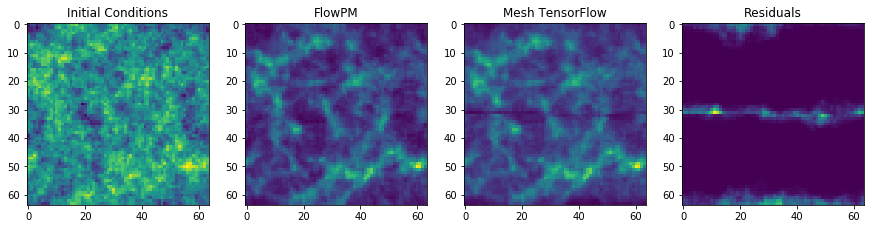

In [17]:
figure(figsize=(15,5))

subplot(141)
imshow(a[0].sum(axis=2))
title('Initial Conditions')

subplot(142)
imshow(b[0].sum(axis=2))
title('FlowPM')

subplot(143)
imshow(c[0].sum(axis=2))
title('Mesh TensorFlow')

subplot(144)
imshow((b[0] - c[0]).sum(axis=2))
title('Residuals')